In [1]:
import pandas as pd
ensemble_df = pd.read_csv("experiments/Outlier_Detection/Results_ENSEMBLED_['COPOD']_all_datasets.csv")
vgan_df = pd.read_csv("experiments/Outlier_Detection/Results_VGAN_['COPOD']_all_datasets.csv")
full_df =  pd.read_csv("experiments/Outlier_Detection/Results_['COPOD']_all_datasets.csv")
pvalue_df = pd.read_csv("experiments/Outlier_Detection/Results_GOF_VGAN_all_datasets.csv")
statistics_df = pd.read_csv("experiments/Outlier_Detection/dataset_statistics.csv")

# Function to group by Dataset and Method, and calculate the average AUC
def group_by_dataset_method_avg_auc(df):
    grouped_df = df.groupby(['Dataset', 'Method'])['AUC'].mean().reset_index()
    return grouped_df

# Apply the function to the loaded dataframe
vgan_df = group_by_dataset_method_avg_auc(vgan_df)
ensemble_df = group_by_dataset_method_avg_auc(ensemble_df)
full_df = group_by_dataset_method_avg_auc(full_df)

grouped_df_1 = pd.merge(ensemble_df,full_df[['Dataset','AUC']], on = 'Dataset', how = 'outer')
grouped_df = pd.merge(grouped_df_1, vgan_df[['Dataset','AUC']], on = 'Dataset', how = 'outer')
grouped_df = grouped_df.rename(columns = {'AUC_x': 'ENSEMBLE', 'AUC_y': 'FULL SPACE', 'AUC':'VGAN'})

joined_df = pd.merge(grouped_df, pvalue_df[['Dataset', 'p-value']], on='Dataset', how='inner')
final_df = pd.merge(statistics_df[['Dataset','# Samples','# Features','# Anomaly','% Anomaly']], joined_df, on='Dataset', how='inner')

final_df.to_csv("res.csv", sep=";")

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
latex_preamble = """
\\usepackage[utf8]{inputenc}
\\usepackage{microtype}
\\usepackage{amsmath}
\\renewcommand{\\rmdefault}{ptm}
\\renewcommand{\\sfdefault}{phv}
"""
fs = 9
column_width = 3.3249219444  # inch
text_width = 7.02625  # inch
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": latex_preamble,
    "font.family": "serif",
    "font.serif": [],
    "font.sans-serif": [],
    "font.monospace": [],
    "font.size": fs,
    "xtick.labelsize": fs,
    "ytick.labelsize": fs,
    "legend.fontsize": fs,
    "savefig.bbox": "tight",
})


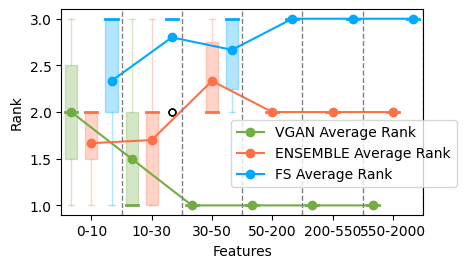

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('experiments/Outlier_Detection/Full_table_with_ranks.csv', delimiter=';')

# Correcting the p-value for the "optdigits" dataset
df.loc[df['Data'] == 'optdigits', 'p-value'] = 0

# Convert p-value column to numeric
df['p-value'] = pd.to_numeric(df['p-value'].str.replace(',',
                              '.'), errors='coerce')

# Filter the datasets where p-value > 0.10
filtered_pvalue_df = df
filtered_pvalue_df = df[df['p-value'] > 0.10]

#Define the colors to use
vgan_color = "#72AD44"
ensemble_color = "#FF7046"
fs_color = "#00A9FF"


# Further filter by the feature ranges
filtered_pvalue_0_10 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] > 0) & (filtered_pvalue_df['# Features'] <= 8)]
filtered_pvalue_10_30 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 10) & (filtered_pvalue_df['# Features'] <= 30)]
filtered_pvalue_30_50 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] > 30) & (filtered_pvalue_df['# Features'] < 50)]
filtered_pvalue_50_100 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 50) & (filtered_pvalue_df['# Features'] <= 200)]
filtered_pvalue_100_300 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 200) & (filtered_pvalue_df['# Features'] <= 550)]
filtered_pvalue_300_700 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 550) & (filtered_pvalue_df['# Features'] <= 2000)]
filtered_pvalue_700_2000 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 700) & (filtered_pvalue_df['# Features'] <= 2000)]

# Extract VGAN, ENSEMBLE, and FS ranks for these filtered datasets
vgan_pvalue_ranks_0_10 = filtered_pvalue_0_10['RANK VGAN']
vgan_pvalue_ranks_10_30 = filtered_pvalue_10_30['RANK VGAN']
vgan_pvalue_ranks_30_50 = filtered_pvalue_30_50['RANK VGAN']
vgan_pvalue_ranks_50_100 = filtered_pvalue_50_100['RANK VGAN']
vgan_pvalue_ranks_100_300 = filtered_pvalue_100_300['RANK VGAN']
vgan_pvalue_ranks_300_700 = filtered_pvalue_300_700['RANK VGAN']
vgan_pvalue_ranks_700_2000 = filtered_pvalue_700_2000['RANK VGAN']

ensemble_pvalue_ranks_0_10 = filtered_pvalue_0_10['RANK ENS']
ensemble_pvalue_ranks_10_30 = filtered_pvalue_10_30['RANK ENS']
ensemble_pvalue_ranks_30_50 = filtered_pvalue_30_50['RANK ENS']
ensemble_pvalue_ranks_50_100 = filtered_pvalue_50_100['RANK ENS']
ensemble_pvalue_ranks_100_300 = filtered_pvalue_100_300['RANK ENS']
ensemble_pvalue_ranks_300_700 = filtered_pvalue_300_700['RANK ENS']
ensemble_pvalue_ranks_700_2000 = filtered_pvalue_700_2000['RANK ENS']

fs_pvalue_ranks_0_10 = filtered_pvalue_0_10['RANK FS']
fs_pvalue_ranks_10_30 = filtered_pvalue_10_30['RANK FS']
fs_pvalue_ranks_30_50 = filtered_pvalue_30_50['RANK FS']
fs_pvalue_ranks_50_100 = filtered_pvalue_50_100['RANK FS']
fs_pvalue_ranks_100_300 = filtered_pvalue_100_300['RANK FS']
fs_pvalue_ranks_300_700 = filtered_pvalue_300_700['RANK FS']
fs_pvalue_ranks_700_2000 = filtered_pvalue_700_2000['RANK FS']

# Calculating the average ranks for each group
all_averages = {
    "0-10": vgan_pvalue_ranks_0_10.mean(),
    "10-30": vgan_pvalue_ranks_10_30.mean(),
    "30-50": vgan_pvalue_ranks_30_50.mean(),
    "50-100": vgan_pvalue_ranks_50_100.mean(),
    "100-300": vgan_pvalue_ranks_100_300.mean(),
    "300-700": vgan_pvalue_ranks_300_700.mean(),
    "700-2000": vgan_pvalue_ranks_700_2000.mean()
}


# Creating the combined boxplot with individual boxplots, line plots of the average ranks, and vertical lines to indicate group limits
plt.figure(figsize=(2*7/3, 2*4/3))

# Creating the boxplots for VGAN, ENSEMBLE, and FS
boxplot_vgan = plt.boxplot(
    [vgan_pvalue_ranks_0_10, vgan_pvalue_ranks_10_30, vgan_pvalue_ranks_30_50, vgan_pvalue_ranks_50_100,
        vgan_pvalue_ranks_100_300, vgan_pvalue_ranks_300_700],
    positions=[1, 4, 7, 10, 13, 16],
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=vgan_color, color=vgan_color, alpha=0.3),
    whiskerprops=dict(color=vgan_color, alpha=0.3),
    capprops=dict(color=vgan_color, alpha=0.3),
    medianprops=dict(color=vgan_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5,
                    linestyle='none', linewidth=2, color=vgan_color)
)

boxplot_ensemble = plt.boxplot(
    [ensemble_pvalue_ranks_0_10, ensemble_pvalue_ranks_10_30, ensemble_pvalue_ranks_30_50, ensemble_pvalue_ranks_50_100,
        ensemble_pvalue_ranks_100_300, ensemble_pvalue_ranks_300_700],
    positions=[2, 5, 8, 11, 14, 17],
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=ensemble_color, color=ensemble_color, alpha=0.3),
    whiskerprops=dict(color=ensemble_color, alpha=0.3),
    capprops=dict(color=ensemble_color, alpha=0.3),
    medianprops=dict(color=ensemble_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5, linestyle='none',
                    linewidth=2, color=ensemble_color)
)

boxplot_fs = plt.boxplot(
    [fs_pvalue_ranks_0_10, fs_pvalue_ranks_10_30, fs_pvalue_ranks_30_50, fs_pvalue_ranks_50_100,
        fs_pvalue_ranks_100_300, fs_pvalue_ranks_300_700],
    positions=[3, 6, 9, 12, 15, 18],
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=fs_color, color=fs_color, alpha=0.3),
    whiskerprops=dict(color=fs_color, alpha=0.3),
    capprops=dict(color=fs_color, alpha=0.3),
    medianprops=dict(color=fs_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5, linestyle='none',
                    linewidth=2, color=fs_color)
)

# Plotting the average ranks for VGAN, ENSEMBLE, and FS as line plots on top of the boxplots
plt.plot(
    [1, 4, 7, 10, 13, 16],
    [all_averages["0-10"], all_averages["10-30"], all_averages["30-50"], all_averages["50-100"],
        all_averages["100-300"], all_averages["300-700"]],
    color=vgan_color, marker='o', linestyle='-', linewidth=1.5, label='VGAN Average Rank'
)

plt.plot(
    [2, 5, 8, 11, 14, 17],
    [ensemble_pvalue_ranks_0_10.mean(), ensemble_pvalue_ranks_10_30.mean(), ensemble_pvalue_ranks_30_50.mean(), ensemble_pvalue_ranks_50_100.mean(),
     ensemble_pvalue_ranks_100_300.mean(), ensemble_pvalue_ranks_300_700.mean()],
    color=ensemble_color, marker='o', linestyle='-', linewidth=1.5, label='ENSEMBLE Average Rank'
)

plt.plot(
    [3, 6, 9, 12, 15, 18],
    [fs_pvalue_ranks_0_10.mean(), fs_pvalue_ranks_10_30.mean(), fs_pvalue_ranks_30_50.mean(), fs_pvalue_ranks_50_100.mean(),
     fs_pvalue_ranks_100_300.mean(), fs_pvalue_ranks_300_700.mean()],
    color=fs_color, marker='o', linestyle='-', linewidth=1.5, label='FS Average Rank'
)

# Adding vertical lines to indicate the limits of each group on the x-axis
for x in [3.5, 6.5, 9.5, 12.5, 15.5, 18.5]:
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=1)

# Setting the x-axis labels
plt.xticks([2, 5, 8, 11, 14, 17], ['0-10', '10-30',
           '30-50', '50-200', '200-550', '550-2000'])

plt.xlabel('Features')
plt.ylabel('Rank')
legend = plt.legend()
legend.set_alpha(.1)
legend.set_bbox_to_anchor((.45,.1))
plt.savefig('LOF.png',dpi=1000)
plt.show()

In [5]:
vgan_pvalue_ranks_100_300

13    1
Name: RANK VGAN, dtype: int64

In [60]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp

# Load the data
df = pd.read_csv('experiments/Outlier_Detection/Full_table_with_ranks.csv', delimiter=';')


df['p-value'] = pd.to_numeric(df['p-value'].str.replace(',',
                              '.'), errors='coerce')
df = df[df['p-value'] > 0.10]

# Extracting the ranks for each model
ranks_ens = df['RANK ENS']
ranks_fs = df['RANK FS']
ranks_vgan = df['RANK VGAN']

# Performing the Kruskal-Wallis test
kruskal_result = stats.kruskal(ranks_ens, ranks_fs, ranks_vgan)
print(f"Kruskal-Wallis Test Result: {kruskal_result}")

# If the p-value from Kruskal-Wallis test is significant, perform Conover-Iman test
if kruskal_result.pvalue < 0.05:
    conover_result = sp.posthoc_conover([ranks_ens, ranks_fs, ranks_vgan], p_adjust='holm')
    conover_result.index = ["Feature Bagging", "Full-Space", "VGAN"]
    conover_result.columns =  ["Feature Bagging", "Full-Space", "VGAN"]
    print("Conover-Iman Test Result:\n", conover_result)
    
else:
    print("Kruskal-Wallis test is not significant; no need to perform Conover-Iman test.")
print(f"Count of datasets:{df.index.__len__()}")

Kruskal-Wallis Test Result: KruskalResult(statistic=41.46153846153849, pvalue=9.9252468636048e-10)
Conover-Iman Test Result:
                  Feature Bagging    Full-Space          VGAN
Feature Bagging         1.000000  1.548208e-06  1.925507e-04
Full-Space              0.000002  1.000000e+00  1.124141e-13
VGAN                    0.000193  1.124141e-13  1.000000e+00
Count of datasets:26


In [36]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp

# Load the data
df = pd.read_csv('experiments/Outlier_Detection/Full_table_with_ranks.csv', delimiter=';')

# Correcting the p-value for the "optdigits" dataset
df.loc[df['Data'] == 'optdigits', 'p-value'] = 0
df['p-value'] = pd.to_numeric(df['p-value'].str.replace(',',
                              '.'), errors='coerce')
df = df[df['p-value'] < 0.10]

# Extracting the ranks for each model
ranks_ens = df['RANK ENS']
ranks_fs = df['RANK FS']
ranks_vgan = df['RANK VGAN']

# Performing the Kruskal-Wallis test
kruskal_result = stats.kruskal(ranks_ens, ranks_fs, ranks_vgan)
print(f"Kruskal-Wallis Test Result: {kruskal_result}")

# If the p-value from Kruskal-Wallis test is significant, perform Conover-Iman test
if kruskal_result.pvalue < 0.05:
    conover_result = sp.posthoc_conover([ranks_ens, ranks_fs, ranks_vgan], p_adjust='holm')
    conover_result.index = ["Feature Bagging", "Full-Space", "VGAN"]
    conover_result.columns =  ["Feature Bagging", "Full-Space", "VGAN"]
    print("Conover-Iman Test Result:\n", conover_result)
    
else:
    print("Kruskal-Wallis test is not significant; no need to perform Conover-Iman test.")
print(f"Count of datasets:{df.index.__len__()}")

Kruskal-Wallis Test Result: KruskalResult(statistic=10.06128888946965, pvalue=0.006534598026026722)
Conover-Iman Test Result:
                  Feature Bagging  Full-Space      VGAN
Feature Bagging         1.000000    0.017277  0.578376
Full-Space              0.017277    1.000000  0.005784
VGAN                    0.578376    0.005784  1.000000
Count of datasets:14


# KNN

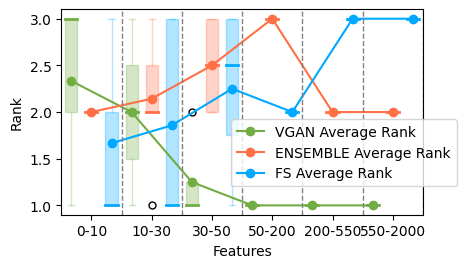

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

#Define the dataset 
dataset = "KNN"
# Load the CSV file
df = pd.read_csv(f'experiments/Outlier_Detection/Full_table_with_ranks-{dataset}.csv', delimiter=',',)

# Filter the datasets where p-value > 0.10
filtered_pvalue_df = df
filtered_pvalue_df = df[df['p-value'] > 0.10]

#Define the colors to use
vgan_color = "#72AD44"
ensemble_color = "#FF7046"
fs_color = "#00A9FF"


# Further filter by the feature ranges
filtered_pvalue_0_10 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] > 0) & (filtered_pvalue_df['# Features'] <= 8)]
filtered_pvalue_10_30 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 10) & (filtered_pvalue_df['# Features'] <= 30)]
filtered_pvalue_30_50 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] > 30) & (filtered_pvalue_df['# Features'] < 50)]
filtered_pvalue_50_100 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 50) & (filtered_pvalue_df['# Features'] <= 200)]
filtered_pvalue_100_300 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 200) & (filtered_pvalue_df['# Features'] <= 550)]
filtered_pvalue_300_700 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 550) & (filtered_pvalue_df['# Features'] <= 2000)]
filtered_pvalue_700_2000 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 700) & (filtered_pvalue_df['# Features'] <= 2000)]

# Extract VGAN, ENSEMBLE, and FS ranks for these filtered datasets
vgan_pvalue_ranks_0_10 = filtered_pvalue_0_10['RANK VGAN']
vgan_pvalue_ranks_10_30 = filtered_pvalue_10_30['RANK VGAN']
vgan_pvalue_ranks_30_50 = filtered_pvalue_30_50['RANK VGAN']
vgan_pvalue_ranks_50_100 = filtered_pvalue_50_100['RANK VGAN']
vgan_pvalue_ranks_100_300 = filtered_pvalue_100_300['RANK VGAN']
vgan_pvalue_ranks_300_700 = filtered_pvalue_300_700['RANK VGAN']
vgan_pvalue_ranks_700_2000 = filtered_pvalue_700_2000['RANK VGAN']

ensemble_pvalue_ranks_0_10 = filtered_pvalue_0_10['RANK ENS']
ensemble_pvalue_ranks_10_30 = filtered_pvalue_10_30['RANK ENS']
ensemble_pvalue_ranks_30_50 = filtered_pvalue_30_50['RANK ENS']
ensemble_pvalue_ranks_50_100 = filtered_pvalue_50_100['RANK ENS']
ensemble_pvalue_ranks_100_300 = filtered_pvalue_100_300['RANK ENS']
ensemble_pvalue_ranks_300_700 = filtered_pvalue_300_700['RANK ENS']
ensemble_pvalue_ranks_700_2000 = filtered_pvalue_700_2000['RANK ENS']

fs_pvalue_ranks_0_10 = filtered_pvalue_0_10['RANK FS']
fs_pvalue_ranks_10_30 = filtered_pvalue_10_30['RANK FS']
fs_pvalue_ranks_30_50 = filtered_pvalue_30_50['RANK FS']
fs_pvalue_ranks_50_100 = filtered_pvalue_50_100['RANK FS']
fs_pvalue_ranks_100_300 = filtered_pvalue_100_300['RANK FS']
fs_pvalue_ranks_300_700 = filtered_pvalue_300_700['RANK FS']
fs_pvalue_ranks_700_2000 = filtered_pvalue_700_2000['RANK FS']

# Calculating the average ranks for each group
all_averages = {
    "0-10": vgan_pvalue_ranks_0_10.mean(),
    "10-30": vgan_pvalue_ranks_10_30.mean(),
    "30-50": vgan_pvalue_ranks_30_50.mean(),
    "50-100": vgan_pvalue_ranks_50_100.mean(),
    "100-300": vgan_pvalue_ranks_100_300.mean(),
    "300-700": vgan_pvalue_ranks_300_700.mean(),
    "700-2000": vgan_pvalue_ranks_700_2000.mean()
}


# Creating the combined boxplot with individual boxplots, line plots of the average ranks, and vertical lines to indicate group limits
plt.figure(figsize=(2*7/3, 2*4/3))

# Creating the boxplots for VGAN, ENSEMBLE, and FS
boxplot_vgan = plt.boxplot(
    [vgan_pvalue_ranks_0_10, vgan_pvalue_ranks_10_30, vgan_pvalue_ranks_30_50, vgan_pvalue_ranks_50_100,
        vgan_pvalue_ranks_100_300, vgan_pvalue_ranks_300_700],
    positions=[1, 4, 7, 10, 13, 16],
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=vgan_color, color=vgan_color, alpha=0.3),
    whiskerprops=dict(color=vgan_color, alpha=0.3),
    capprops=dict(color=vgan_color, alpha=0.3),
    medianprops=dict(color=vgan_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5,
                    linestyle='none', linewidth=2, color=vgan_color)
)

boxplot_ensemble = plt.boxplot(
    [ensemble_pvalue_ranks_0_10, ensemble_pvalue_ranks_10_30, ensemble_pvalue_ranks_30_50, ensemble_pvalue_ranks_50_100,
        ensemble_pvalue_ranks_100_300, ensemble_pvalue_ranks_300_700],
    positions=[2, 5, 8, 11, 14, 17],
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=ensemble_color, color=ensemble_color, alpha=0.3),
    whiskerprops=dict(color=ensemble_color, alpha=0.3),
    capprops=dict(color=ensemble_color, alpha=0.3),
    medianprops=dict(color=ensemble_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5, linestyle='none',
                    linewidth=2, color=ensemble_color)
)

boxplot_fs = plt.boxplot(
    [fs_pvalue_ranks_0_10, fs_pvalue_ranks_10_30, fs_pvalue_ranks_30_50, fs_pvalue_ranks_50_100,
        fs_pvalue_ranks_100_300, fs_pvalue_ranks_300_700],
    positions=[3, 6, 9, 12, 15, 18],
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=fs_color, color=fs_color, alpha=0.3),
    whiskerprops=dict(color=fs_color, alpha=0.3),
    capprops=dict(color=fs_color, alpha=0.3),
    medianprops=dict(color=fs_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5, linestyle='none',
                    linewidth=2, color=fs_color)
)

# Plotting the average ranks for VGAN, ENSEMBLE, and FS as line plots on top of the boxplots
plt.plot(
    [1, 4, 7, 10, 13, 16],
    [all_averages["0-10"], all_averages["10-30"], all_averages["30-50"], all_averages["50-100"],
        all_averages["100-300"], all_averages["300-700"]],
    color=vgan_color, marker='o', linestyle='-', linewidth=1.5, label='VGAN Average Rank'
)

plt.plot(
    [2, 5, 8, 11, 14, 17],
    [ensemble_pvalue_ranks_0_10.mean(), ensemble_pvalue_ranks_10_30.mean(), ensemble_pvalue_ranks_30_50.mean(), ensemble_pvalue_ranks_50_100.mean(),
     ensemble_pvalue_ranks_100_300.mean(), ensemble_pvalue_ranks_300_700.mean()],
    color=ensemble_color, marker='o', linestyle='-', linewidth=1.5, label='ENSEMBLE Average Rank'
)

plt.plot(
    [3, 6, 9, 12, 15, 18],
    [fs_pvalue_ranks_0_10.mean(), fs_pvalue_ranks_10_30.mean(), fs_pvalue_ranks_30_50.mean(), fs_pvalue_ranks_50_100.mean(),
     fs_pvalue_ranks_100_300.mean(), fs_pvalue_ranks_300_700.mean()],
    color=fs_color, marker='o', linestyle='-', linewidth=1.5, label='FS Average Rank'
)

# Adding vertical lines to indicate the limits of each group on the x-axis
for x in [3.5, 6.5, 9.5, 12.5, 15.5, 18.5]:
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=1)

# Setting the x-axis labels
plt.xticks([2, 5, 8, 11, 14, 17], ['0-10', '10-30',
           '30-50', '50-200', '200-550', '550-2000'])

plt.xlabel('Features')
plt.ylabel('Rank')
legend = plt.legend()
legend.set_alpha(.1)
legend.set_bbox_to_anchor((.45,.301))
plt.savefig(f'{dataset}.png',dpi=1000)
plt.show()

In [25]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp

# Load the data
df = pd.read_csv('experiments/Outlier_Detection/Full_table_with_ranks-KNN.csv', delimiter=',')


df = df[df['p-value'] > 0.10]

# Extracting the ranks for each model
ranks_ens = df['RANK ENS']
ranks_fs = df['RANK FS']
ranks_vgan = df['RANK VGAN']

# Performing the Kruskal-Wallis test
kruskal_result = stats.kruskal(ranks_ens, ranks_fs, ranks_vgan)
print(f"Kruskal-Wallis Test Result: {kruskal_result}")

# If the p-value from Kruskal-Wallis test is significant, perform Conover-Iman test
if kruskal_result.pvalue < 0.05:
    conover_result = sp.posthoc_conover([ranks_ens, ranks_fs, ranks_vgan])
    conover_result.index = ["Feature Bagging", "Full-Space", "VGAN"]
    conover_result.columns =  ["Feature Bagging", "Full-Space", "VGAN"]
    print("Conover-Iman Test Result:\n", conover_result)
    
else:
    print("Kruskal-Wallis test is not significant; no need to perform Conover-Iman test.")
print(f"Count of datasets:{df.index.__len__()}")

Kruskal-Wallis Test Result: KruskalResult(statistic=8.57596371882086, pvalue=0.013732611691505504)
Conover-Iman Test Result:
                  Feature Bagging  Full-Space      VGAN
Feature Bagging         1.000000    0.843185  0.012255
Full-Space              0.843185    1.000000  0.007220
VGAN                    0.012255    0.007220  1.000000
Count of datasets:21


In [26]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp

# Load the data
df = pd.read_csv('experiments/Outlier_Detection/Full_table_with_ranks-KNN.csv', delimiter=',')


df = df[df['p-value'] < 0.10]

# Extracting the ranks for each model
ranks_ens = df['RANK ENS']
ranks_fs = df['RANK FS']
ranks_vgan = df['RANK VGAN']

# Performing the Kruskal-Wallis test
kruskal_result = stats.kruskal(ranks_ens, ranks_fs, ranks_vgan)
print(f"Kruskal-Wallis Test Result: {kruskal_result}")

# If the p-value from Kruskal-Wallis test is significant, perform Conover-Iman test
conover_result = sp.posthoc_conover([ranks_ens, ranks_fs, ranks_vgan])
conover_result.index = ["Feature Bagging", "Full-Space", "VGAN"]
conover_result.columns =  ["Feature Bagging", "Full-Space", "VGAN"]
print("Conover-Iman Test Result:\n", conover_result)
    
print(f"Count of datasets:{df.index.__len__()}")

Kruskal-Wallis Test Result: KruskalResult(statistic=0.5914342372968273, pvalue=0.7439978613755436)
Conover-Iman Test Result:
                  Feature Bagging  Full-Space      VGAN
Feature Bagging         1.000000    0.450491  0.685985
Full-Space              0.450491    1.000000  0.725114
VGAN                    0.685985    0.725114  1.000000
Count of datasets:21


# CBLOF

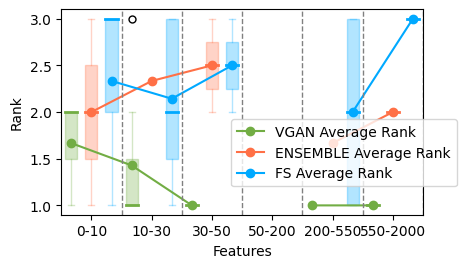

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

#Define the dataset 
dataset = "CBLOF"
# Load the CSV file
df = pd.read_csv(f'experiments/Outlier_Detection/Full_table_with_ranks-{dataset}.csv', delimiter=',',)

# Filter the datasets where p-value > 0.10
filtered_pvalue_df = df
filtered_pvalue_df = df[df['p-value'] > 0.10]

#Define the colors to use
vgan_color = "#72AD44"
ensemble_color = "#FF7046"
fs_color = "#00A9FF"


# Further filter by the feature ranges
filtered_pvalue_0_10 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] > 0) & (filtered_pvalue_df['# Features'] <= 8)]
filtered_pvalue_10_30 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 10) & (filtered_pvalue_df['# Features'] <= 30)]
filtered_pvalue_30_50 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] > 30) & (filtered_pvalue_df['# Features'] < 50)]
filtered_pvalue_50_100 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 50) & (filtered_pvalue_df['# Features'] <= 200)]
filtered_pvalue_100_300 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 200) & (filtered_pvalue_df['# Features'] <= 550)]
filtered_pvalue_300_700 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 550) & (filtered_pvalue_df['# Features'] <= 2000)]
filtered_pvalue_700_2000 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 700) & (filtered_pvalue_df['# Features'] <= 2000)]

# Extract VGAN, ENSEMBLE, and FS ranks for these filtered datasets
vgan_pvalue_ranks_0_10 = filtered_pvalue_0_10['RANK VGAN']
vgan_pvalue_ranks_10_30 = filtered_pvalue_10_30['RANK VGAN']
vgan_pvalue_ranks_30_50 = filtered_pvalue_30_50['RANK VGAN']
vgan_pvalue_ranks_50_100 = filtered_pvalue_50_100['RANK VGAN']
vgan_pvalue_ranks_100_300 = filtered_pvalue_100_300['RANK VGAN']
vgan_pvalue_ranks_300_700 = filtered_pvalue_300_700['RANK VGAN']
vgan_pvalue_ranks_700_2000 = filtered_pvalue_700_2000['RANK VGAN']

ensemble_pvalue_ranks_0_10 = filtered_pvalue_0_10['RANK ENS']
ensemble_pvalue_ranks_10_30 = filtered_pvalue_10_30['RANK ENS']
ensemble_pvalue_ranks_30_50 = filtered_pvalue_30_50['RANK ENS']
ensemble_pvalue_ranks_50_100 = filtered_pvalue_50_100['RANK ENS']
ensemble_pvalue_ranks_100_300 = filtered_pvalue_100_300['RANK ENS']
ensemble_pvalue_ranks_300_700 = filtered_pvalue_300_700['RANK ENS']
ensemble_pvalue_ranks_700_2000 = filtered_pvalue_700_2000['RANK ENS']

fs_pvalue_ranks_0_10 = filtered_pvalue_0_10['RANK FS']
fs_pvalue_ranks_10_30 = filtered_pvalue_10_30['RANK FS']
fs_pvalue_ranks_30_50 = filtered_pvalue_30_50['RANK FS']
fs_pvalue_ranks_50_100 = filtered_pvalue_50_100['RANK FS']
fs_pvalue_ranks_100_300 = filtered_pvalue_100_300['RANK FS']
fs_pvalue_ranks_300_700 = filtered_pvalue_300_700['RANK FS']
fs_pvalue_ranks_700_2000 = filtered_pvalue_700_2000['RANK FS']

# Calculating the average ranks for each group
all_averages = {
    "0-10": vgan_pvalue_ranks_0_10.mean(),
    "10-30": vgan_pvalue_ranks_10_30.mean(),
    "30-50": vgan_pvalue_ranks_30_50.mean(),
    "50-100": vgan_pvalue_ranks_50_100.mean(),
    "100-300": vgan_pvalue_ranks_100_300.mean(),
    "300-700": vgan_pvalue_ranks_300_700.mean(),
    "700-2000": vgan_pvalue_ranks_700_2000.mean()
}


# Creating the combined boxplot with individual boxplots, line plots of the average ranks, and vertical lines to indicate group limits
plt.figure(figsize=(2*7/3, 2*4/3))

# Creating the boxplots for VGAN, ENSEMBLE, and FS
boxplot_vgan = plt.boxplot(
    [vgan_pvalue_ranks_0_10, vgan_pvalue_ranks_10_30, vgan_pvalue_ranks_30_50, vgan_pvalue_ranks_50_100,
        vgan_pvalue_ranks_100_300, vgan_pvalue_ranks_300_700],
    positions=[1, 4, 7, 10, 13, 16],
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=vgan_color, color=vgan_color, alpha=0.3),
    whiskerprops=dict(color=vgan_color, alpha=0.3),
    capprops=dict(color=vgan_color, alpha=0.3),
    medianprops=dict(color=vgan_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5,
                    linestyle='none', linewidth=2, color=vgan_color)
)

boxplot_ensemble = plt.boxplot(
    [ensemble_pvalue_ranks_0_10, ensemble_pvalue_ranks_10_30, ensemble_pvalue_ranks_30_50, ensemble_pvalue_ranks_50_100,
        ensemble_pvalue_ranks_100_300, ensemble_pvalue_ranks_300_700],
    positions=[2, 5, 8, 11, 14, 17],
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=ensemble_color, color=ensemble_color, alpha=0.3),
    whiskerprops=dict(color=ensemble_color, alpha=0.3),
    capprops=dict(color=ensemble_color, alpha=0.3),
    medianprops=dict(color=ensemble_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5, linestyle='none',
                    linewidth=2, color=ensemble_color)
)

boxplot_fs = plt.boxplot(
    [fs_pvalue_ranks_0_10, fs_pvalue_ranks_10_30, fs_pvalue_ranks_30_50, fs_pvalue_ranks_50_100,
        fs_pvalue_ranks_100_300, fs_pvalue_ranks_300_700],
    positions=[3, 6, 9, 12, 15, 18],
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=fs_color, color=fs_color, alpha=0.3),
    whiskerprops=dict(color=fs_color, alpha=0.3),
    capprops=dict(color=fs_color, alpha=0.3),
    medianprops=dict(color=fs_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5, linestyle='none',
                    linewidth=2, color=fs_color)
)

# Plotting the average ranks for VGAN, ENSEMBLE, and FS as line plots on top of the boxplots
plt.plot(
    [1, 4, 7, 10, 13, 16],
    [all_averages["0-10"], all_averages["10-30"], all_averages["30-50"], all_averages["50-100"],
        all_averages["100-300"], all_averages["300-700"]],
    color=vgan_color, marker='o', linestyle='-', linewidth=1.5, label='VGAN Average Rank'
)

plt.plot(
    [2, 5, 8, 11, 14, 17],
    [ensemble_pvalue_ranks_0_10.mean(), ensemble_pvalue_ranks_10_30.mean(), ensemble_pvalue_ranks_30_50.mean(), ensemble_pvalue_ranks_50_100.mean(),
     ensemble_pvalue_ranks_100_300.mean(), ensemble_pvalue_ranks_300_700.mean()],
    color=ensemble_color, marker='o', linestyle='-', linewidth=1.5, label='ENSEMBLE Average Rank'
)

plt.plot(
    [3, 6, 9, 12, 15, 18],
    [fs_pvalue_ranks_0_10.mean(), fs_pvalue_ranks_10_30.mean(), fs_pvalue_ranks_30_50.mean(), fs_pvalue_ranks_50_100.mean(),
     fs_pvalue_ranks_100_300.mean(), fs_pvalue_ranks_300_700.mean()],
    color=fs_color, marker='o', linestyle='-', linewidth=1.5, label='FS Average Rank'
)

# Adding vertical lines to indicate the limits of each group on the x-axis
for x in [3.5, 6.5, 9.5, 12.5, 15.5, 18.5]:
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=1)

# Setting the x-axis labels
plt.xticks([2, 5, 8, 11, 14, 17], ['0-10', '10-30',
           '30-50', '50-200', '200-550', '550-2000'])

plt.xlabel('Features')
plt.ylabel('Rank')
legend = plt.legend()
legend.set_alpha(.1)
legend.set_bbox_to_anchor((.45,.301))
plt.savefig(f'{dataset}.png',dpi=1000)
plt.show()

In [5]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp

# Load the data
df = pd.read_csv('experiments/Outlier_Detection/Full_table_with_ranks-CBLOF.csv', delimiter=',')


df = df[df['p-value'] > 0.10].drop("Columna 1", axis=1).dropna()

# Extracting the ranks for each model
ranks_ens = df['RANK ENS']
ranks_fs = df['RANK FS']
ranks_vgan = df['RANK VGAN']

# Performing the Kruskal-Wallis test
kruskal_result = stats.kruskal(ranks_ens, ranks_fs, ranks_vgan)
print(f"Kruskal-Wallis Test Result: {kruskal_result}")

# If the p-value from Kruskal-Wallis test is significant, perform Conover-Iman test

conover_result = sp.posthoc_conover([ranks_ens, ranks_fs, ranks_vgan])
conover_result.index = ["Feature Bagging", "Full-Space", "VGAN"]
conover_result.columns =  ["Feature Bagging", "Full-Space", "VGAN"]
print("Conover-Iman Test Result:\n", conover_result)
    
print(f"Count of datasets:{df.index.__len__()}")

Kruskal-Wallis Test Result: KruskalResult(statistic=3.4489325068870276, pvalue=0.1782681764097062)
Conover-Iman Test Result:
                  Feature Bagging  Full-Space      VGAN
Feature Bagging         1.000000    0.233980  0.069333
Full-Space              0.233980    1.000000  0.516248
VGAN                    0.069333    0.516248  1.000000
Count of datasets:16


In [42]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp

# Load the data
df = pd.read_csv('experiments/Outlier_Detection/Full_table_with_ranks.csv', delimiter=';')


df['p-value'] = pd.to_numeric(df['p-value'].str.replace(',',
                              '.'), errors='coerce')
df = df[df['p-value'] < 0.10]

# Extracting the ranks for each model
ranks_ens = df['RANK ENS']
ranks_fs = df['RANK FS']
ranks_vgan = df['RANK VGAN']

# Performing the Kruskal-Wallis test
kruskal_result = stats.kruskal(ranks_ens, ranks_fs, ranks_vgan)
print(f"Kruskal-Wallis Test Result: {kruskal_result}")

# If the p-value from Kruskal-Wallis test is significant, perform Conover-Iman test
if kruskal_result.pvalue < 0.05:
    conover_result = sp.posthoc_conover([ranks_ens, ranks_fs, ranks_vgan], p_adjust='holm')
    conover_result.index = ["Feature Bagging", "Full-Space", "VGAN"]
    conover_result.columns =  ["Feature Bagging", "Full-Space", "VGAN"]
    print("Conover-Iman Test Result:\n", conover_result)
    
else:
    print("Kruskal-Wallis test is not significant; no need to perform Conover-Iman test.")
print(f"Count of datasets:{df.index.__len__()}")

Kruskal-Wallis Test Result: KruskalResult(statistic=7.478103166344593, pvalue=0.02377664260916227)
Conover-Iman Test Result:
                  Feature Bagging  Full-Space      VGAN
Feature Bagging         1.000000    0.085394  0.465640
Full-Space              0.085394    1.000000  0.021531
VGAN                    0.465640    0.021531  1.000000
Count of datasets:15


# ECOD 

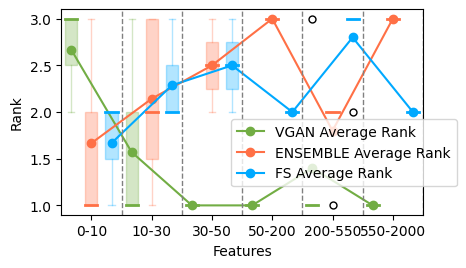

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

#Define the dataset 
dataset = "ECOD"
# Load the CSV file
df = pd.read_csv(f'experiments/Outlier_Detection/Full_table_with_ranks-{dataset}.csv', delimiter=',',)

# Filter the datasets where p-value > 0.10
filtered_pvalue_df = df
filtered_pvalue_df = df[df['p-value'] > 0.10]

#Define the colors to use
vgan_color = "#72AD44"
ensemble_color = "#FF7046"
fs_color = "#00A9FF"


# Further filter by the feature ranges
filtered_pvalue_0_10 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] > 0) & (filtered_pvalue_df['# Features'] <= 8)]
filtered_pvalue_10_30 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 10) & (filtered_pvalue_df['# Features'] <= 30)]
filtered_pvalue_30_50 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] > 30) & (filtered_pvalue_df['# Features'] < 50)]
filtered_pvalue_50_100 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 50) & (filtered_pvalue_df['# Features'] <= 200)]
filtered_pvalue_100_300 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 200) & (filtered_pvalue_df['# Features'] <= 550)]
filtered_pvalue_300_700 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 550) & (filtered_pvalue_df['# Features'] <= 2000)]
filtered_pvalue_700_2000 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 700) & (filtered_pvalue_df['# Features'] <= 2000)]

# Extract VGAN, ENSEMBLE, and FS ranks for these filtered datasets
vgan_pvalue_ranks_0_10 = filtered_pvalue_0_10['RANK VGAN']
vgan_pvalue_ranks_10_30 = filtered_pvalue_10_30['RANK VGAN']
vgan_pvalue_ranks_30_50 = filtered_pvalue_30_50['RANK VGAN']
vgan_pvalue_ranks_50_100 = filtered_pvalue_50_100['RANK VGAN']
vgan_pvalue_ranks_100_300 = filtered_pvalue_100_300['RANK VGAN']
vgan_pvalue_ranks_300_700 = filtered_pvalue_300_700['RANK VGAN']
vgan_pvalue_ranks_700_2000 = filtered_pvalue_700_2000['RANK VGAN']

ensemble_pvalue_ranks_0_10 = filtered_pvalue_0_10['RANK ENS']
ensemble_pvalue_ranks_10_30 = filtered_pvalue_10_30['RANK ENS']
ensemble_pvalue_ranks_30_50 = filtered_pvalue_30_50['RANK ENS']
ensemble_pvalue_ranks_50_100 = filtered_pvalue_50_100['RANK ENS']
ensemble_pvalue_ranks_100_300 = filtered_pvalue_100_300['RANK ENS']
ensemble_pvalue_ranks_300_700 = filtered_pvalue_300_700['RANK ENS']
ensemble_pvalue_ranks_700_2000 = filtered_pvalue_700_2000['RANK ENS']

fs_pvalue_ranks_0_10 = filtered_pvalue_0_10['RANK FS']
fs_pvalue_ranks_10_30 = filtered_pvalue_10_30['RANK FS']
fs_pvalue_ranks_30_50 = filtered_pvalue_30_50['RANK FS']
fs_pvalue_ranks_50_100 = filtered_pvalue_50_100['RANK FS']
fs_pvalue_ranks_100_300 = filtered_pvalue_100_300['RANK FS']
fs_pvalue_ranks_300_700 = filtered_pvalue_300_700['RANK FS']
fs_pvalue_ranks_700_2000 = filtered_pvalue_700_2000['RANK FS']

# Calculating the average ranks for each group
all_averages = {
    "0-10": vgan_pvalue_ranks_0_10.mean(),
    "10-30": vgan_pvalue_ranks_10_30.mean(),
    "30-50": vgan_pvalue_ranks_30_50.mean(),
    "50-100": vgan_pvalue_ranks_50_100.mean(),
    "100-300": vgan_pvalue_ranks_100_300.mean(),
    "300-700": vgan_pvalue_ranks_300_700.mean(),
    "700-2000": vgan_pvalue_ranks_700_2000.mean()
}


# Creating the combined boxplot with individual boxplots, line plots of the average ranks, and vertical lines to indicate group limits
plt.figure(figsize=(2*7/3, 2*4/3))

# Creating the boxplots for VGAN, ENSEMBLE, and FS
boxplot_vgan = plt.boxplot(
    [vgan_pvalue_ranks_0_10, vgan_pvalue_ranks_10_30, vgan_pvalue_ranks_30_50, vgan_pvalue_ranks_50_100,
        vgan_pvalue_ranks_100_300, vgan_pvalue_ranks_300_700],
    positions=[1, 4, 7, 10, 13, 16],
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=vgan_color, color=vgan_color, alpha=0.3),
    whiskerprops=dict(color=vgan_color, alpha=0.3),
    capprops=dict(color=vgan_color, alpha=0.3),
    medianprops=dict(color=vgan_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5,
                    linestyle='none', linewidth=2, color=vgan_color)
)

boxplot_ensemble = plt.boxplot(
    [ensemble_pvalue_ranks_0_10, ensemble_pvalue_ranks_10_30, ensemble_pvalue_ranks_30_50, ensemble_pvalue_ranks_50_100,
        ensemble_pvalue_ranks_100_300, ensemble_pvalue_ranks_300_700],
    positions=[2, 5, 8, 11, 14, 17],
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=ensemble_color, color=ensemble_color, alpha=0.3),
    whiskerprops=dict(color=ensemble_color, alpha=0.3),
    capprops=dict(color=ensemble_color, alpha=0.3),
    medianprops=dict(color=ensemble_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5, linestyle='none',
                    linewidth=2, color=ensemble_color)
)

boxplot_fs = plt.boxplot(
    [fs_pvalue_ranks_0_10, fs_pvalue_ranks_10_30, fs_pvalue_ranks_30_50, fs_pvalue_ranks_50_100,
        fs_pvalue_ranks_100_300, fs_pvalue_ranks_300_700],
    positions=[3, 6, 9, 12, 15, 18],
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=fs_color, color=fs_color, alpha=0.3),
    whiskerprops=dict(color=fs_color, alpha=0.3),
    capprops=dict(color=fs_color, alpha=0.3),
    medianprops=dict(color=fs_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5, linestyle='none',
                    linewidth=2, color=fs_color)
)

# Plotting the average ranks for VGAN, ENSEMBLE, and FS as line plots on top of the boxplots
plt.plot(
    [1, 4, 7, 10, 13, 16],
    [all_averages["0-10"], all_averages["10-30"], all_averages["30-50"], all_averages["50-100"],
        all_averages["100-300"], all_averages["300-700"]],
    color=vgan_color, marker='o', linestyle='-', linewidth=1.5, label='VGAN Average Rank'
)

plt.plot(
    [2, 5, 8, 11, 14, 17],
    [ensemble_pvalue_ranks_0_10.mean(), ensemble_pvalue_ranks_10_30.mean(), ensemble_pvalue_ranks_30_50.mean(), ensemble_pvalue_ranks_50_100.mean(),
     ensemble_pvalue_ranks_100_300.mean(), ensemble_pvalue_ranks_300_700.mean()],
    color=ensemble_color, marker='o', linestyle='-', linewidth=1.5, label='ENSEMBLE Average Rank'
)

plt.plot(
    [3, 6, 9, 12, 15, 18],
    [fs_pvalue_ranks_0_10.mean(), fs_pvalue_ranks_10_30.mean(), fs_pvalue_ranks_30_50.mean(), fs_pvalue_ranks_50_100.mean(),
     fs_pvalue_ranks_100_300.mean(), fs_pvalue_ranks_300_700.mean()],
    color=fs_color, marker='o', linestyle='-', linewidth=1.5, label='FS Average Rank'
)

# Adding vertical lines to indicate the limits of each group on the x-axis
for x in [3.5, 6.5, 9.5, 12.5, 15.5, 18.5]:
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=1)

# Setting the x-axis labels
plt.xticks([2, 5, 8, 11, 14, 17], ['0-10', '10-30',
           '30-50', '50-200', '200-550', '550-2000'])

plt.xlabel('Features')
plt.ylabel('Rank')
legend = plt.legend()
legend.set_alpha(.1)
legend.set_bbox_to_anchor((.45,.301))
plt.savefig(f'{dataset}.png',dpi=1000)
plt.show()

In [8]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp

# Load the data
df = pd.read_csv('experiments/Outlier_Detection/Full_table_with_ranks-ECOD.csv', delimiter=',')



df = df[df['p-value'] > 0.10]

# Extracting the ranks for each model
ranks_ens = df['RANK ENS']
ranks_fs = df['RANK FS']
ranks_vgan = df['RANK VGAN']

# Performing the Kruskal-Wallis test
kruskal_result = stats.kruskal(ranks_ens, ranks_fs, ranks_vgan)
print(f"Kruskal-Wallis Test Result: {kruskal_result}")

# If the p-value from Kruskal-Wallis test is significant, perform Conover-Iman test
if kruskal_result.pvalue < 0.05:
    conover_result = sp.posthoc_conover([ranks_ens, ranks_fs, ranks_vgan])
    conover_result.index = ["Feature Bagging", "Full-Space", "VGAN"]
    conover_result.columns =  ["Feature Bagging", "Full-Space", "VGAN"]
    print("Conover-Iman Test Result:\n", conover_result)
    
else:
    print("Kruskal-Wallis test is not significant; no need to perform Conover-Iman test.")
print(f"Count of datasets:{df.index.__len__()}")

Kruskal-Wallis Test Result: KruskalResult(statistic=8.066481994459814, pvalue=0.017716816650088577)
Conover-Iman Test Result:
                  Feature Bagging  Full-Space      VGAN
Feature Bagging         1.000000    0.406795  0.041323
Full-Space              0.406795    1.000000  0.005010
VGAN                    0.041323    0.005010  1.000000
Count of datasets:19


In [10]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp

# Load the data
df = pd.read_csv('experiments/Outlier_Detection/Full_table_with_ranks-ECOD.csv', delimiter=',')



df = df[df['p-value'] < 0.10]

# Extracting the ranks for each model
ranks_ens = df['RANK ENS']
ranks_fs = df['RANK FS']
ranks_vgan = df['RANK VGAN']

# Performing the Kruskal-Wallis test
kruskal_result = stats.kruskal(ranks_ens, ranks_fs, ranks_vgan)
print(f"Kruskal-Wallis Test Result: {kruskal_result}")

# If the p-value from Kruskal-Wallis test is significant, perform Conover-Iman test

conover_result = sp.posthoc_conover([ranks_ens, ranks_fs, ranks_vgan])
conover_result.index = ["Feature Bagging", "Full-Space", "VGAN"]
conover_result.columns =  ["Feature Bagging", "Full-Space", "VGAN"]
print("Conover-Iman Test Result:\n", conover_result)
    
print(f"Count of datasets:{df.index.__len__()}")

Kruskal-Wallis Test Result: KruskalResult(statistic=0.1285444234404692, pvalue=0.9377496983257851)
Conover-Iman Test Result:
                  Feature Bagging  Full-Space      VGAN
Feature Bagging         1.000000    0.860225  0.860225
Full-Space              0.860225    1.000000  0.724800
VGAN                    0.860225    0.724800  1.000000
Count of datasets:23


# COPOD

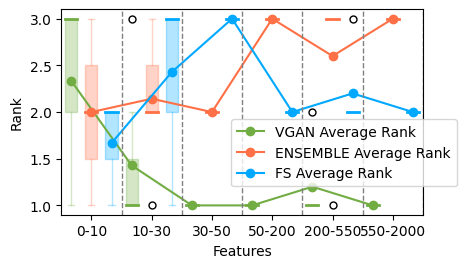

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

#Define the dataset 
dataset = "COPOD"
# Load the CSV file
df = pd.read_csv(f'experiments/Outlier_Detection/Full_table_with_ranks-{dataset}.csv', delimiter=',',)

# Filter the datasets where p-value > 0.10
filtered_pvalue_df = df
filtered_pvalue_df = df[df['p-value'] > 0.10]

#Define the colors to use
vgan_color = "#72AD44"
ensemble_color = "#FF7046"
fs_color = "#00A9FF"


# Further filter by the feature ranges
filtered_pvalue_0_10 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] > 0) & (filtered_pvalue_df['# Features'] <= 8)]
filtered_pvalue_10_30 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 10) & (filtered_pvalue_df['# Features'] <= 30)]
filtered_pvalue_30_50 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] > 30) & (filtered_pvalue_df['# Features'] < 50)]
filtered_pvalue_50_100 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 50) & (filtered_pvalue_df['# Features'] <= 200)]
filtered_pvalue_100_300 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 200) & (filtered_pvalue_df['# Features'] <= 550)]
filtered_pvalue_300_700 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 550) & (filtered_pvalue_df['# Features'] <= 2000)]
filtered_pvalue_700_2000 = filtered_pvalue_df[(
    filtered_pvalue_df['# Features'] >= 700) & (filtered_pvalue_df['# Features'] <= 2000)]

# Extract VGAN, ENSEMBLE, and FS ranks for these filtered datasets
vgan_pvalue_ranks_0_10 = filtered_pvalue_0_10['RANK VGAN']
vgan_pvalue_ranks_10_30 = filtered_pvalue_10_30['RANK VGAN']
vgan_pvalue_ranks_30_50 = filtered_pvalue_30_50['RANK VGAN']
vgan_pvalue_ranks_50_100 = filtered_pvalue_50_100['RANK VGAN']
vgan_pvalue_ranks_100_300 = filtered_pvalue_100_300['RANK VGAN']
vgan_pvalue_ranks_300_700 = filtered_pvalue_300_700['RANK VGAN']
vgan_pvalue_ranks_700_2000 = filtered_pvalue_700_2000['RANK VGAN']

ensemble_pvalue_ranks_0_10 = filtered_pvalue_0_10['RANK ENS']
ensemble_pvalue_ranks_10_30 = filtered_pvalue_10_30['RANK ENS']
ensemble_pvalue_ranks_30_50 = filtered_pvalue_30_50['RANK ENS']
ensemble_pvalue_ranks_50_100 = filtered_pvalue_50_100['RANK ENS']
ensemble_pvalue_ranks_100_300 = filtered_pvalue_100_300['RANK ENS']
ensemble_pvalue_ranks_300_700 = filtered_pvalue_300_700['RANK ENS']
ensemble_pvalue_ranks_700_2000 = filtered_pvalue_700_2000['RANK ENS']

fs_pvalue_ranks_0_10 = filtered_pvalue_0_10['RANK FS']
fs_pvalue_ranks_10_30 = filtered_pvalue_10_30['RANK FS']
fs_pvalue_ranks_30_50 = filtered_pvalue_30_50['RANK FS']
fs_pvalue_ranks_50_100 = filtered_pvalue_50_100['RANK FS']
fs_pvalue_ranks_100_300 = filtered_pvalue_100_300['RANK FS']
fs_pvalue_ranks_300_700 = filtered_pvalue_300_700['RANK FS']
fs_pvalue_ranks_700_2000 = filtered_pvalue_700_2000['RANK FS']

# Calculating the average ranks for each group
all_averages = {
    "0-10": vgan_pvalue_ranks_0_10.mean(),
    "10-30": vgan_pvalue_ranks_10_30.mean(),
    "30-50": vgan_pvalue_ranks_30_50.mean(),
    "50-100": vgan_pvalue_ranks_50_100.mean(),
    "100-300": vgan_pvalue_ranks_100_300.mean(),
    "300-700": vgan_pvalue_ranks_300_700.mean(),
    "700-2000": vgan_pvalue_ranks_700_2000.mean()
}


# Creating the combined boxplot with individual boxplots, line plots of the average ranks, and vertical lines to indicate group limits
plt.figure(figsize=(2*7/3, 2*4/3))

# Creating the boxplots for VGAN, ENSEMBLE, and FS
boxplot_vgan = plt.boxplot(
    [vgan_pvalue_ranks_0_10, vgan_pvalue_ranks_10_30, vgan_pvalue_ranks_30_50, vgan_pvalue_ranks_50_100,
        vgan_pvalue_ranks_100_300, vgan_pvalue_ranks_300_700],
    positions=[1, 4, 7, 10, 13, 16],
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=vgan_color, color=vgan_color, alpha=0.3),
    whiskerprops=dict(color=vgan_color, alpha=0.3),
    capprops=dict(color=vgan_color, alpha=0.3),
    medianprops=dict(color=vgan_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5,
                    linestyle='none', linewidth=2, color=vgan_color)
)

boxplot_ensemble = plt.boxplot(
    [ensemble_pvalue_ranks_0_10, ensemble_pvalue_ranks_10_30, ensemble_pvalue_ranks_30_50, ensemble_pvalue_ranks_50_100,
        ensemble_pvalue_ranks_100_300, ensemble_pvalue_ranks_300_700],
    positions=[2, 5, 8, 11, 14, 17],
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=ensemble_color, color=ensemble_color, alpha=0.3),
    whiskerprops=dict(color=ensemble_color, alpha=0.3),
    capprops=dict(color=ensemble_color, alpha=0.3),
    medianprops=dict(color=ensemble_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5, linestyle='none',
                    linewidth=2, color=ensemble_color)
)

boxplot_fs = plt.boxplot(
    [fs_pvalue_ranks_0_10, fs_pvalue_ranks_10_30, fs_pvalue_ranks_30_50, fs_pvalue_ranks_50_100,
        fs_pvalue_ranks_100_300, fs_pvalue_ranks_300_700],
    positions=[3, 6, 9, 12, 15, 18],
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor=fs_color, color=fs_color, alpha=0.3),
    whiskerprops=dict(color=fs_color, alpha=0.3),
    capprops=dict(color=fs_color, alpha=0.3),
    medianprops=dict(color=fs_color,linewidth=2),
    flierprops=dict(marker='o', markersize=5, linestyle='none',
                    linewidth=2, color=fs_color)
)

# Plotting the average ranks for VGAN, ENSEMBLE, and FS as line plots on top of the boxplots
plt.plot(
    [1, 4, 7, 10, 13, 16],
    [all_averages["0-10"], all_averages["10-30"], all_averages["30-50"], all_averages["50-100"],
        all_averages["100-300"], all_averages["300-700"]],
    color=vgan_color, marker='o', linestyle='-', linewidth=1.5, label='VGAN Average Rank'
)

plt.plot(
    [2, 5, 8, 11, 14, 17],
    [ensemble_pvalue_ranks_0_10.mean(), ensemble_pvalue_ranks_10_30.mean(), ensemble_pvalue_ranks_30_50.mean(), ensemble_pvalue_ranks_50_100.mean(),
     ensemble_pvalue_ranks_100_300.mean(), ensemble_pvalue_ranks_300_700.mean()],
    color=ensemble_color, marker='o', linestyle='-', linewidth=1.5, label='ENSEMBLE Average Rank'
)

plt.plot(
    [3, 6, 9, 12, 15, 18],
    [fs_pvalue_ranks_0_10.mean(), fs_pvalue_ranks_10_30.mean(), fs_pvalue_ranks_30_50.mean(), fs_pvalue_ranks_50_100.mean(),
     fs_pvalue_ranks_100_300.mean(), fs_pvalue_ranks_300_700.mean()],
    color=fs_color, marker='o', linestyle='-', linewidth=1.5, label='FS Average Rank'
)

# Adding vertical lines to indicate the limits of each group on the x-axis
for x in [3.5, 6.5, 9.5, 12.5, 15.5, 18.5]:
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=1)

# Setting the x-axis labels
plt.xticks([2, 5, 8, 11, 14, 17], ['0-10', '10-30',
           '30-50', '50-200', '200-550', '550-2000'])

plt.xlabel('Features')
plt.ylabel('Rank')
legend = plt.legend()
legend.set_alpha(.1)
legend.set_bbox_to_anchor((.45,.301))
plt.savefig(f'{dataset}.png',dpi=1000)
plt.show()

In [8]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp

# Load the data
df = pd.read_csv('experiments/Outlier_Detection/Full_table_with_ranks-COPOD.csv', delimiter=',')



df = df[df['p-value'] > 0.10]

# Extracting the ranks for each model
ranks_ens = df['RANK ENS']
ranks_fs = df['RANK FS']
ranks_vgan = df['RANK VGAN']

# Performing the Kruskal-Wallis test
kruskal_result = stats.kruskal(ranks_ens, ranks_fs, ranks_vgan)
print(f"Kruskal-Wallis Test Result: {kruskal_result}")

# If the p-value from Kruskal-Wallis test is significant, perform Conover-Iman test

conover_result = sp.posthoc_conover([ranks_ens, ranks_fs, ranks_vgan])
conover_result.index = ["Feature Bagging", "Full-Space", "VGAN"]
conover_result.columns =  ["Feature Bagging", "Full-Space", "VGAN"]
print("Conover-Iman Test Result:\n", conover_result)
    
print(f"Count of datasets:{df.index.__len__()}")

Kruskal-Wallis Test Result: KruskalResult(statistic=17.85487528344671, pvalue=0.00013269760809115318)
Conover-Iman Test Result:
                  Feature Bagging  Full-Space      VGAN
Feature Bagging         1.000000    0.827731  0.000106
Full-Space              0.827731    1.000000  0.000050
VGAN                    0.000106    0.000050  1.000000
Count of datasets:21


In [9]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp

# Load the data
df = pd.read_csv('experiments/Outlier_Detection/Full_table_with_ranks-COPOD.csv', delimiter=',')



df = df[df['p-value'] < 0.10]

# Extracting the ranks for each model
ranks_ens = df['RANK ENS']
ranks_fs = df['RANK FS']
ranks_vgan = df['RANK VGAN']

# Performing the Kruskal-Wallis test
kruskal_result = stats.kruskal(ranks_ens, ranks_fs, ranks_vgan)
print(f"Kruskal-Wallis Test Result: {kruskal_result}")

# If the p-value from Kruskal-Wallis test is significant, perform Conover-Iman test

conover_result = sp.posthoc_conover([ranks_ens, ranks_fs, ranks_vgan])
conover_result.index = ["Feature Bagging", "Full-Space", "VGAN"]
conover_result.columns =  ["Feature Bagging", "Full-Space", "VGAN"]
print("Conover-Iman Test Result:\n", conover_result)
    
print(f"Count of datasets:{df.index.__len__()}")

Kruskal-Wallis Test Result: KruskalResult(statistic=2.921280593916538, pvalue=0.23208762214542708)
Conover-Iman Test Result:
                  Feature Bagging  Full-Space      VGAN
Feature Bagging         1.000000    0.142808  0.989274
Full-Space              0.142808    1.000000  0.139275
VGAN                    0.989274    0.139275  1.000000
Count of datasets:21


FOR TESTING UNIFORMITY

In [ ]:
import math 

def pmf(x,feat_number, number_of_experiments): 
    sub_number = 2**feat_number
    summatory = 0
    for k in range(x):
        summatory += (-1)**k*math.comb(x,k)*((x-k)//sub_number)**number_of_experiments
    return math.comb(sub_number,x)*summatory
def cdf(x,feat_number, number_of_experiments):
    summatory = 0
    for k in range(x+1):
        print(k)
        summatory += pmf(k,feat_number, number_of_experiments)
    return summatory